## Augmentation

In [1]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqn
%matplotlib inline

sys.path.append('..')

import meters as ms
from meters.batch import MeterBatch
from meters.dataset import B,V,F,R,P, FilesIndex, Dataset, Pipeline
from meters.dataset.dataset.models.tf import ResNet18, DenseNet121, VGG19


plt.style.use('seaborn-poster')
plt.style.use('ggplot')

/home/grisha/anaconda3/envs/tf/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
src = '../newone/data/blosc_images/'

fileindex = FilesIndex(path=src+'*blosc', no_ext=True)

dset = Dataset(fileindex, batch_class=MeterBatch)
dset.cv_split()

In [3]:
shape_to_feed = (200, 200)

load_ppl = \
    Pipeline()\
    .load(src=src, fmt='blosc', components='images')\
    .load(src='../newone/data/labels/new_labels.csv',\
          fmt='csv',\
          components=['coordinates', 'labels'],\
          index_col='file_name')\
    .convert_bbox(src='coordinates', dst='coordinates')\
    .remove_background(dst='images')\
    .resize_bb(shape=shape_to_feed,\
               src=['images', 'coordinates'],\
               dst=['images', 'coordinates'])

In [4]:
def factor_sampler(size):
    return np.random.uniform(0.7, 1.3, (size,2))

def shift_sampler(size):
    return np.c_[np.random.uniform(-20, 20, (size,2)),0]
 
augmentation_ppl = \
    Pipeline()\
    .scale(factor=P(R(factor_sampler)),\
           src=['images', 'coordinates'],\
           dst=['images', 'coordinates'],\
           p=0.5,\
           preserve_shape=True)\
    .shift(shift=P(R(shift_sampler)),\
           src=['images', 'coordinates'],\
           dst=['images', 'coordinates'],\
           p=0.5)\
    .rotate(angle=P(R('normal',loc=0, scale=6)),\
            src=['images', 'coordinates'],\
            dst=['images', 'coordinates'],\
            p=0.5)\
    .multiply(multiplier=1/255., preserve_type=False)\
    .multiply(multiplier=P(R('uniform', 0.3, 1.5)), p=0.5)\
    .salt(size=lambda: np.random.randint(1, 10, 2),\
          color=lambda: np.random.uniform(0, 1, 3),\
          p_noise=P(R('uniform', 0.001, 0.005)),\
          p=0.5)\
    .posterize(colors_number=R('randint',2,50), p=0.5)\
    .multiplicative_noise(noise=lambda size: np.random.uniform(0.7, 1.3,size=size), p=0.3)\
    .additive_noise(noise=lambda size: np.random.normal(0, 0.01,size=size), p=0.3)\
    .gaussian_filter(sigma=P(R('uniform', 0.5, 2)), p=0.3)


bbox_pipeline = ((load_ppl + augmentation_ppl) << dset)

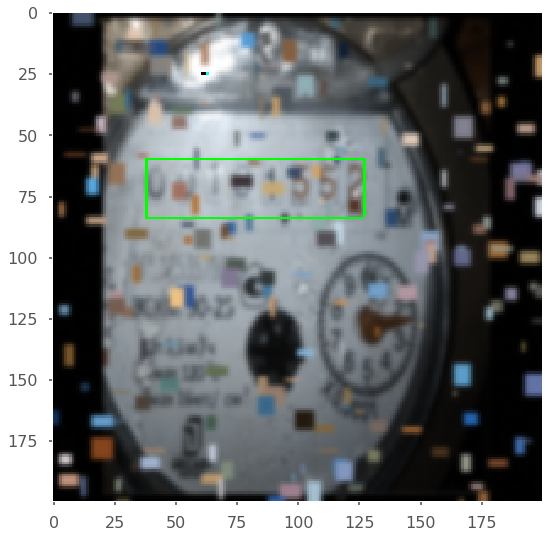

In [5]:
from IPython.display import clear_output
from time import sleep

def add_bb(img, bb, c, width=2):
    lc, lr, w, h = bb.astype(np.int)
    im_height = img.shape[0] - 1
    im_width = img.shape[1] - 1
    for i in range(width):
        img[min(im_height,lr):min(im_height,lr)+i, min(im_width,lc):min(im_width,lc+w),:]=c
        img[min(im_height,lr):min(im_height,lr+h), min(im_width,lc):min(im_width,lc)+i,:]=c
        img[min(im_height,lr):min(im_height,lr+h), min(im_width,lc+w):min(im_width,lc+w)+i,:]=c
        img[min(im_height,lr+h):min(im_height,lr+h)+i, min(im_width,lc):min(im_width,lc+w),:]=c
    return img

for i in range(len(bbox_pipeline)):
    clear_output(True)
    batch = bbox_pipeline.next_batch(1, shuffle=False)
    image = batch.images[0].copy()
    bbox = batch.coordinates[0]
    plt.figure(figsize=(9,9))
    plt.imshow(add_bb(image, bbox, [0,1,0], 2))
    plt.grid(False)
    plt.show()
    sleep(0.1)